# Data-OOB for random forests and bagged classifiers

This notebook illustrates the use of [Data-OOB][../../value/data-oob] from Kwon and Zou "[Data-OOB: Out-of-bag Estimate as a Simple and Efficient Data Value](https://proceedings.mlr.press/v202/kwon23e.html)" (ICML 2023), to compute values for bagged models.

We will work with the [adult classification dataset](https://archive.ics.uci.edu/dataset/2/adult) from the UCI repository. It's an imbalanced dataset where the objective is to predict whether a person earns more than $50K a year (the "positive" class) based on a set of features such as age, education, occupation, etc. After training a random forest on this dataset, we will compute the Data-OOB values and analyze them.


## Setup

<div class="alert alert-info">

If you are reading this in the documentation, some boilerplate (including most plotting code) has been omitted for convenience.

</div>

We begin by importing the main libraries and setting some defaults.

In [1]:
%load_ext autoreload

import os
import random

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
from support.common import load_adult_data

from pydvl.reporting.plots import plot_ci_array, plot_ci_values

matplotlib.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)
MEAN_COLORS = ["dodgerblue", "indianred", "limegreen", "darkorange", "darkorchid"]
SHADE_COLORS = ["lightskyblue", "firebrick", "seagreen", "gold", "plum"]

is_CI = os.environ.get("CI")
random_state = 42
random.seed(random_state);

In [2]:
from sklearn.ensemble import RandomForestClassifier

from pydvl.valuation import DataOOBValuation, Dataset


With a helper function we download the data, encode the categorical variables using [TargetEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html), and split it into training and testing sets. We must be careful to stratify the split by the target variable (income).

In [3]:
train_size = 0.6
train, test = load_adult_data(
    train_size=train_size, subsample=0.2, random_state=random_state
)

Found cached file: adult_data_raw.pkl.


In [4]:
if is_CI:  # Subsample 1% of the data for faster testing
    train, test = load_adult_data(
        train_size=train_size, subsample=0.01, random_state=random_state
    )

Usually we would carefully look at the features, check for missing values, outliers, etc. But for the sake of this example, we will skip this step and jump straight into training a model. We will only look at the class distribution since it will matter later:

In [6]:
print(
    f"{len(train)} samples. "
    f"Class distribution: {100 * np.mean(train.data().y == 1):.1f}% positive, "
    f"{100 * np.mean(train.data().y == 0):.1f}% negative"
)

3602 samples. Class distribution: 25.0% positive, 75.0% negative


As a quick baseline, we train a standard sklearn [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). Since the dataset is imbalanced, besides the accuracy we look at the confusion matrix, and notice that despite weighting the class by their inverse frequency with `class_weight="balanced"`, the model is not very good at predicting the minority ("positive", or "1") class: in the left hand side of the figure below we see a high rate of false negatives. This will play a role later in how we interpret the values that Data-OOB returns, and requires us to address the imbalance in the dataset. We do this with a simple random over sampling using `imblearn`'s [RandomOverSampler](...) class.

In [7]:
from imblearn.over_sampling import RandomOverSampler

n_est = 50
max_samples = 0.2  # Use small bootstrap samples
model = RandomForestClassifier(
    n_estimators=n_est,
    max_samples=max_samples,
    class_weight="balanced",
    random_state=random_state,
)
model.fit(*train.data())
base_predictions = model.predict(test.data().x)

sampler = RandomOverSampler(random_state=random_state)
resampled_x, resampled_y = sampler.fit_resample(*train.data())
train = Dataset(resampled_x, resampled_y, train.feature_names, train.target_names)

model.fit(*train.data())
predictions_oversampled = model.predict(test.data().x)

In [8]:
print(
    f"{len(train)} samples. Class distribution: "
    f"{100 * train.data().y.mean():.1f}% positive, "
    f"{100 * (1 - train.data().y.mean()):.1f}% negative"
)

5406 samples. Class distribution: 50.0% positive, 50.0% negative


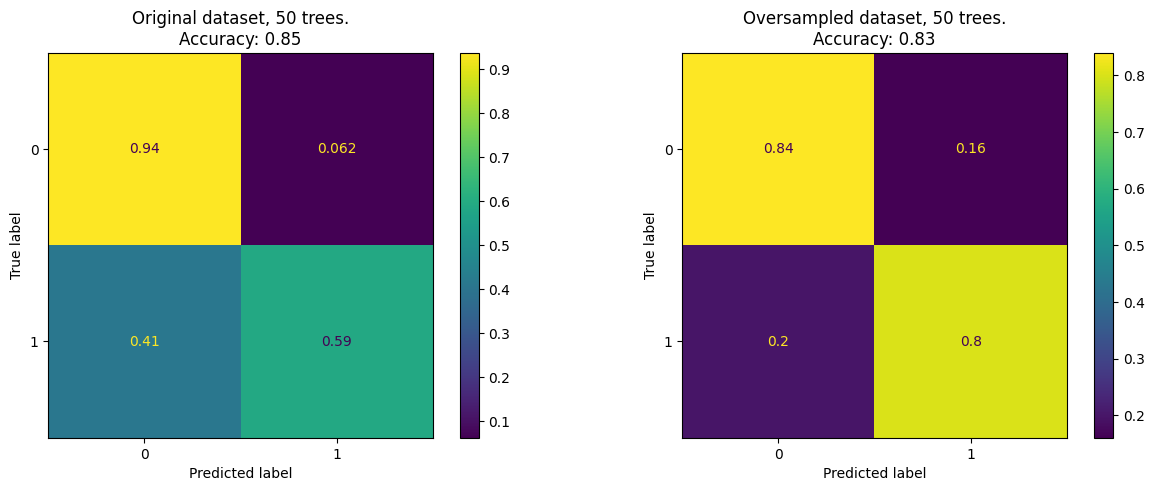

In [9]:
from sklearn.metrics import accuracy_score

base_accuracy = accuracy_score(test.data().y, base_predictions)
accuracy_oversampled = accuracy_score(test.data().y, predictions_oversampled)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ConfusionMatrixDisplay.from_predictions(
    test.data().y, base_predictions, ax=axs[0], labels=[0, 1], normalize="true"
)
ConfusionMatrixDisplay.from_predictions(
    test.data().y, predictions_oversampled, ax=axs[1], labels=[0, 1], normalize="true"
)

axs[0].set_title(f"Original dataset, {n_est} trees.\nAccuracy: {base_accuracy:.2f}")
axs[1].set_title(
    f"Oversampled dataset, {n_est} trees.\nAccuracy: {accuracy_oversampled:.2f}"
)

plt.show()

## Computing the OOB values

The main idea of Data-OOB is to use the out-of-bag error estimates of a bagged model to compute data values. In pyDVL, we provide a class [DataOOBValuation][pydvl.valuation.DataOOBValuation] that takes an existing classification or regression bagging model and uses the per-sample out-of-bag performance estimate for the value of each point.

Let's compute and compare the Data-OOB values with three choices for the number of estimators of a random forest. After fitting the random forest, we use the [fit][pydvl.valuation.DataOOBValuation.fit] method to compute the values and store them in [ValuationResult][pydvl.value.result.ValuationResult] objects.

Even though it's not relevant to our discussion, notice how the accuracy barely changes with the number of estimators. Below, we will discuss using the values to identify "easy" or "hard" samples in the dataset, but first let's quickly look at the values themselves.

In [10]:
n_estimators = [50, 100, 200]
oob_values = []
for i, n_est in enumerate(n_estimators, start=1):
    model = RandomForestClassifier(
        n_estimators=n_est,
        max_samples=max_samples,
        class_weight="balanced",
        random_state=random_state,
    )

    # Tuning messes everything up if we oversample the dataset
    # model = ThresholdTunerCV(classifier, n_splits=6, metric=f1_score, n_jobs=6)
    model.fit(*train.data())
    accuracy = model.score(*test.data())
    print(f"Accuracy with {n_est} estimators: {accuracy:.2f}")
    valuation = DataOOBValuation(model)
    valuation.fit(train)
    oob_values.append(valuation.values())

Accuracy with 50 estimators: 0.83
Accuracy with 100 estimators: 0.83
Accuracy with 200 estimators: 0.83



### The distribution of values

The left-hand side of the figure below depicts value as it increases with rank and a 95% t-confidence interval. The right-hand side shows the histogram of values.

We observe a long tail of high values. This is because the score $T$ used in Data-OOB (accuracy in this case) is a binary variable, and the value $\psi_i$ is the fraction of times that all weak learners not trained on the $i$-th point classify it correctly. Given the imbalance in the dataset, many learners will always predict the majority ("negative", < $50K earnings / year) class and be correct on 75% of the dataset, leading to this tail.

Besides the actual value $\psi_i$, [ValuationResult][pydvl.value.result.ValuationResult] objects store the number of times a sample is OOB —the quantity $\sum_{b=1}^{B} \mathbb{1} (w_{bi}=0)$— in the `counts` attribute, and the variance of the OOB score in the `variances` attribute. We use the latter in the plot below in order to display the confidence intervals, but it is important to note that the interpretation varies from one valuation method to another:

For Shapley-based valuation methods, the variance is that of the marginal changes in the performance of the model when trained on subsets of the data with and without a sample, evaluated on a fixed valuation dataset, and could in principle be used to see whether values have (roughly) converged. But for Data-OOB, it is the variance of the performance of the ensemble of weak learners on the sample when it is OOB. Although similar in spirit, the construction is different and can be misleading.

As a matter of fact, the interpretation of the vanishing variance at the tail has little to do with valuation and everything to do with our dataset, as introduced above: As the number of estimators increases, the chance of all of them failing on the same points decreases, up to a point. The same happens when we increase the maximum depth (try it!). This behaviour is then not a deep property of Data-OOB from which to gain new insights, but rather a consequence of the dataset and the model, as we further elaborate below.

*Note that a symmetric CI is actually incorrect in this situation since all values are bounded between 0 and 1 (instead we could use a bootstrapped CI if we stored the scores of all estimators in the bagging model, but this is not implemented in pyDVL).*


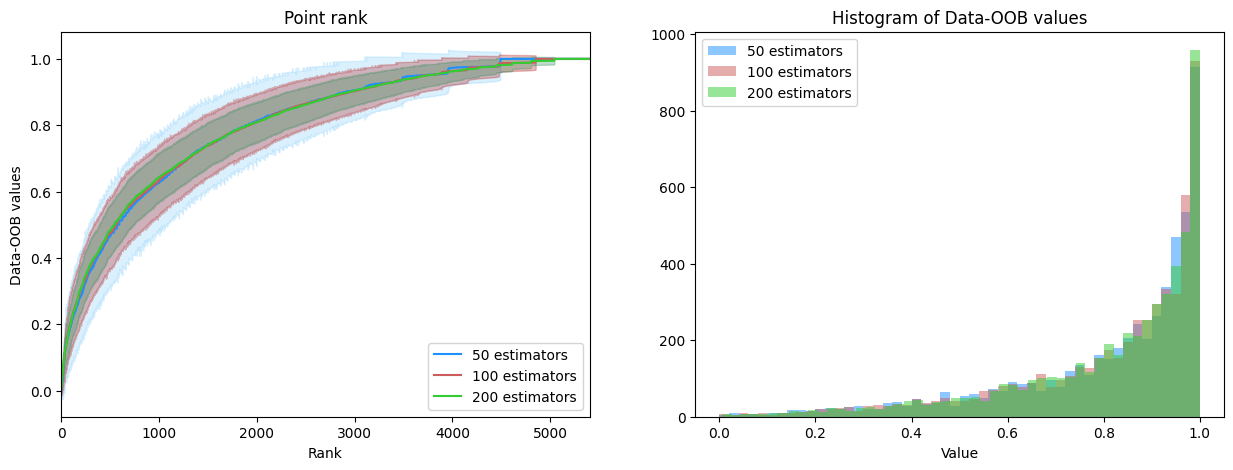

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[15, 5])

for n_est, values, mean_color, shade_color in zip(
    n_estimators, oob_values, MEAN_COLORS, SHADE_COLORS
):
    values.sort()
    plot_ci_values(
        values,
        level=0.05,
        mean_color=mean_color,
        shade_color=shade_color,
        ax=ax1,
        label=f"{n_est} estimators",
    )

    ax2.hist(values, bins=50, color=mean_color, alpha=0.5, label=f"{n_est} estimators")

ax1.set_title("Point rank")
ax1.set_xlabel("Rank")
ax1.set_ylabel("Data-OOB values")
ax1.legend()
ax2.set_title("Histogram of Data-OOB values")
ax2.set_xlabel("Value")
ax2.legend()
plt.plot();

To see this, focus on the long tails with zero variance. These are samples for which the score $T(y_i, \hat{f}_b(x_i)) = 1$ for *every* estimator $\hat{f}_b$ not trained on them, that is: *every weak learner in the ensemble correctly classifies these samples*. As we said above, this can happen because it is likely for weak estimators to be fitted to always predict the majority (negative) class:

In [12]:
v = oob_values[0]
from_index = np.where(np.isclose(v.variances, 0.0) & np.isclose(v.values, 1))[0][0]
tail = values.indices[from_index:]
print(
    f"There are {len(tail)} points with value 1 and zero variance"
    f" ({100 * len(tail) / len(train):.2f}% of the data)."
)
print(
    f"Of these, {100 * (train[tail].data().y == 0).sum() / len(tail):.2f}% "
    f"are in the majority class."
)

There are 914 points with value 1 and zero variance (16.91% of the data).
Of these, 77.46% are in the majority class.


Simply put, the ensemble is mostly good at classifying the majority class, and the variance of the OOB score for these samples is very low. This is a common issue in imbalanced datasets, and it is one of the reasons why the OOB score might not be a good metric for model performance in these cases. For us, it shows that the values reflect only poorly fit models. We test this at the end of the notebook by ensembling a number of constant classifiers.

But first, let's evaluate the conclusion of the previous discussion: at first sight, it seems that for this imbalanced dataset and poorly performing model, the usual intuition that extreme values characterize "easy" or "hard" points might be bogus.

In order to test this idea, we will use a standard experiment in the data valuation literature.

## Evaluating Data-OOB values with data removal

We can systematically evaluate the impact of removing data points with high or low values on the model's performance. If the values are meaningful, we should see a significant change in the model's performance. This is a common practice in the literature.

PyDVL provides  [run_removal_experiment][pydvl.reporting.point_removal.run_removal_experiment], which is a convenience function to compute the performance of the model after removing a fraction of the data with the highest or lowest values.

The details are hidden in the version of this notebook rendered for the documentation, please refer to the actual notebook for the full code.

In order to run the experiment, we need to define 3 types of factories:

1. A factory that returns a train-test split of the data given a random state
2. A factory that returns a utility that evaluates a model on a given test set.
   This is used for the performance evaluation. The model need not be the same
   as the one used for the valuation.
3. A factory returning a valuation method. The training set is passed to the
   factory, in case the valuation needs to train something. E.g. for Data-OOB
   we need the bagging model to be fitted before the valuation is computed.

In [15]:
import warnings

from pydvl.reporting.point_removal import run_removal_experiment
from pydvl.valuation import KNNClassifierUtility, ModelUtility, SupervisedScorer
from pydvl.valuation.methods.data_oob import point_wise_accuracy
from pydvl.valuation.methods.random import RandomValuation

n_est = 50
max_samples = 0.2  # Small bootstrap samples
train_size = 0.6  # Fraction of data for training
random_state = 42


def make_data(random_state: int) -> tuple[Dataset, Dataset]:
    train, test = load_adult_data(train_size=train_size, random_state=random_state)
    # suppress sklearn >= 1.6 warnings originating in imblearn
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sampler = RandomOverSampler(random_state=random_state)
        resampled_x, resampled_y = sampler.fit_resample(*train.data())
    train = Dataset(resampled_x, resampled_y, train.feature_names, train.target_names)
    return train, test


def make_utility(test: Dataset, random_state: int) -> ModelUtility:
    model = RandomForestClassifier(
        n_estimators=n_est,
        max_samples=max_samples,
        class_weight="balanced",
        random_state=random_state + 1,
    )

    return ModelUtility(model, SupervisedScorer("accuracy", test, 0.0))


def make_oob(train: Dataset, random_state: int) -> DataOOBValuation:
    model = RandomForestClassifier(
        n_estimators=n_est,
        max_samples=max_samples,
        class_weight="balanced",
        random_state=random_state,
    )

    model.fit(*train.data())
    return DataOOBValuation(model, point_wise_accuracy)


def make_random(train: Dataset, random_state: int) -> RandomValuation:
    return RandomValuation(random_state=random_state)


removal_percentages = np.arange(0, 0.51, 0.02)

In [18]:
low_scores_df, high_scores_df = run_removal_experiment(
    data_factory=make_data,
    valuation_factories=[make_random, make_oob],
    utility_factory=make_utility,  # for evaluation
    removal_percentages=removal_percentages,
    n_runs=10,
    n_jobs=18,
    random_state=random_state,
)

100%|██████████| 20/20 [01:01<00:00,  3.10s/%]


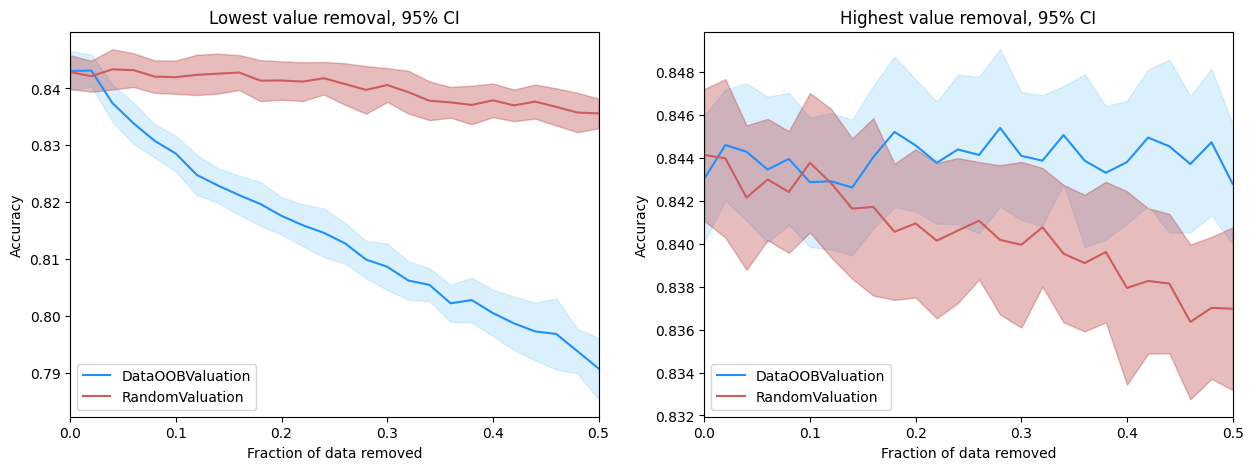

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[15, 5])

for i, scores_df in enumerate((low_scores_df, high_scores_df)):
    for j, (method_name, df) in enumerate(scores_df.groupby("method_name")):
        plot_ci_array(
            data=df.drop(columns=["method_name"]).values,
            level=0.05,
            abscissa=np.round(removal_percentages, 2),
            mean_color=MEAN_COLORS[j],
            shade_color=SHADE_COLORS[j],
            label=method_name,
            ax=axs[i],
        )
        axs[i].legend()
        axs[i].set_ylabel("Accuracy")

axs[0].set_title("Lowest value removal, 95% CI")
axs[0].set_xlabel("Fraction of data removed")
axs[1].set_title("Highest value removal, 95% CI")
axs[1].set_xlabel("Fraction of data removed")

plt.show();

We observe that if we discard the datapoints with the highest values, i.e. those which the ensemble of weak learners classifies correctly every time (maybe because we believe that those are trivial in some sense, e.g. repeated) and bias the ensemble towards stricter decisions boundaries, we obtain very mild changes in performance, even after removing 50% of the data. This is consistent with the fact that the ensemble is mostly good at classifying the majority class.

However, we see a more pronounced sensitivity of the model to the removal of low-valued points, with an average drop of 5% in accuracy after removing 50% of the data with the lowest value, as opposed to barely any change when removing data at random. This is consistent with the fact that the ensemble is not very good at classifying the minority class, and the low-valued points are those that the ensemble gets wrong most of the time.


## Using Data-OOB with arbitrary models

Note that even though the method is designed for bagging models, in principle it can be used with any other estimator by fitting a bagging model on top of it. This can generally be quite expensive, but it might prove useful in some cases. Below is what happens when we do this with a k-nearest neighbors classifier.


In [20]:
from sklearn.neighbors import KNeighborsClassifier


# We want to use the KNN classifier as model for the utility, not the bagged model
def make_knn_utility(test: Dataset, random_state: int) -> ModelUtility:
    return KNNClassifierUtility(KNeighborsClassifier(n_neighbors=10), test)


def make_oob_knn(train: Dataset, random_state: int) -> DataOOBValuation:
    model = BaggingClassifier(
        estimator=KNeighborsClassifier(n_neighbors=10),
        max_samples=0.4,
        n_estimators=10,
        random_state=random_state,
    )
    model.fit(*train.data())
    return DataOOBValuation(model, point_wise_accuracy)


low_scores_df, high_scores_df = run_removal_experiment(
    data_factory=make_data,
    utility_factory=make_knn_utility,
    valuation_factories=[make_random, make_oob_knn],
    removal_percentages=removal_percentages,
    n_runs=10,
    n_jobs=18,
)

100%|██████████| 20/20 [06:19<00:00, 18.96s/%]  


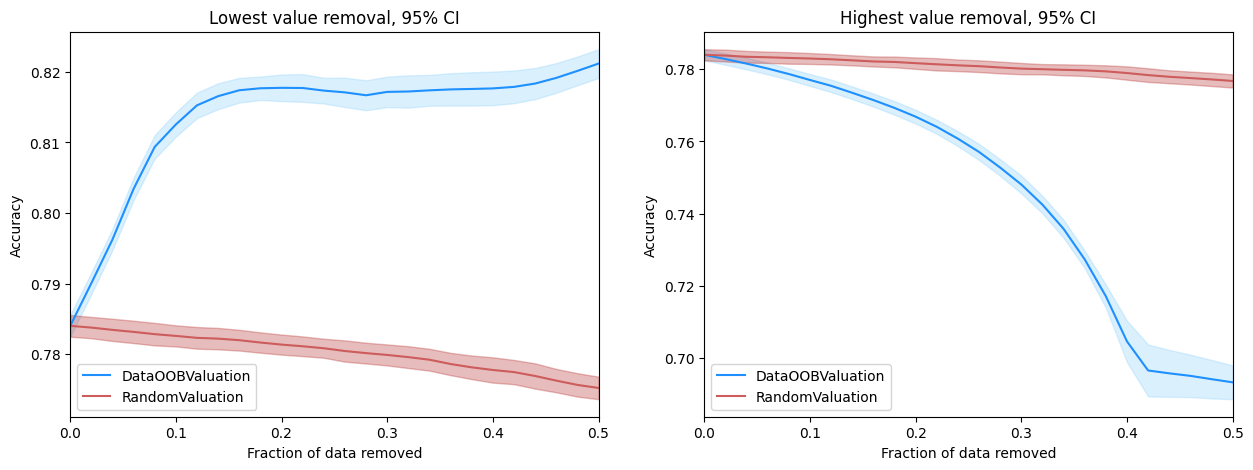

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[15, 5])

for i, scores_df in enumerate((low_scores_df, high_scores_df)):
    for j, (method_name, df) in enumerate(scores_df.groupby("method_name")):
        plot_ci_array(
            data=df.drop(columns=["method_name"]).values,
            level=0.05,
            abscissa=np.round(removal_percentages, 2),
            mean_color=MEAN_COLORS[j],
            shade_color=SHADE_COLORS[j],
            label=method_name,
            ax=axs[i],
        )
        axs[i].legend()
        axs[i].set_ylabel("Accuracy")

axs[0].set_title("Lowest value removal, 95% CI")
axs[0].set_xlabel("Fraction of data removed")
axs[1].set_title("Highest value removal, 95% CI")
axs[1].set_xlabel("Fraction of data removed")

plt.show();

As we can see by the changes in performance, bagging the model and looking at OOB information to rank data points with Data-OOB does provide valuable information for data inspection, cleaning, etc. even when the model is not a bagging model. However, the cost of fitting the bagging model might be prohibitive in some cases.

## Appendix: A detour to further interpret the OOB values

We can verify that the OOB values in our case reflect the imbalance of the dataset by training a [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) with constant estimators. A fraction of `n_estimators` will always pick class 1, and the rest class 0. This leads to a clear jump in the value rank plot, either around 25% or 75% of them, since, as we saw above, 25% of the samples are in the positive ("1") class, and 75% in the negative ("0").

We will use three different probabilities for the constant estimators to predict class 0: 0.01, 0.5, and 0.99. Again, the idea is that the OOB values will reflect the class distribution of the dataset, and we should see a clear jump in the values around 25% and 75% of the data.

The code is analogous to the above when we fitted the random forest, so it is ommitted from the documentation, but we use a custom class `ConstantBinaryClassifier` as base estimator.

In [13]:
from sklearn.ensemble import BaggingClassifier
from support.common import ConstantBinaryClassifier

train, test = load_adult_data(
    train_size=train_size, subsample=0.2, random_state=random_state
)

probs = [0.01, 0.5, 0.99]
all_values = []
for p in probs:
    model = BaggingClassifier(
        ConstantBinaryClassifier(p, random_state),
        n_estimators=100,
        max_samples=1.0,
        random_state=random_state,
    )
    model.fit(*train.data())
    score = model.score(*test.data())
    print(
        f"Accuracy when ~{100 * p:.1f}% of estimators always predict class 0: {score:.4f}"
    )

    valuation = DataOOBValuation(model)
    valuation.fit(train)
    all_values.append(valuation.values())

Found cached file: adult_data_raw.pkl.
Accuracy when ~1.0% of estimators always predict class 0: 0.2498
Accuracy when ~50.0% of estimators always predict class 0: 0.7502
Accuracy when ~99.0% of estimators always predict class 0: 0.7502


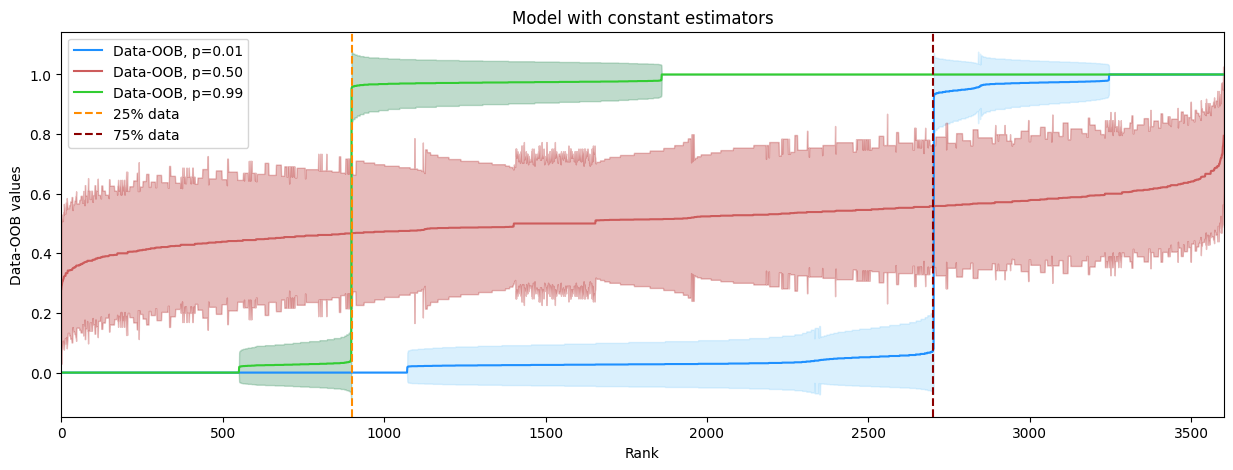

In [14]:
fig, ax = plt.subplots(figsize=[15, 5])

for p, values, mean_color, shade_color in zip(
    probs, all_values, MEAN_COLORS, SHADE_COLORS
):
    values.sort(key="value")
    plot_ci_values(
        values,
        ax=ax,
        level=0.01,
        mean_color=mean_color,
        shade_color=shade_color,
        label=f"Data-OOB, p={p:.2f}",
    )

ax.axvline(
    0.25 * len(all_values[0]), color="darkorange", linestyle="--", label="25% data"
)
ax.axvline(0.75 * len(all_values[0]), color="darkred", linestyle="--", label="75% data")
plt.ylabel("Data-OOB values")
plt.xlabel("Rank")
plt.title("Model with constant estimators")
plt.legend();